In [50]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import logging
logging.basicConfig()

from pathlib import Path
from pprint import pprint
import itertools

from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt
import skimage
import sklearn.mixture
import cv2 as cv

import quinoa as q

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
NOTEBOOK_NAME = "segment_card"

HERE = Path.cwd().absolute()
DATA = HERE.parent / "data"
OUT = HERE / "out" / Path(NOTEBOOK_NAME).stem
print(HERE)
print(DATA)
print(OUT)

D:\projects\quinoa\dev
D:\projects\quinoa\data
D:\projects\quinoa\dev\out\segment_card


In [52]:
# img_bgr = q.read_image(DATA / "IMG_0477.JPG")
# img_bgr = q.read_image(DATA / "IMG_0497.JPG")
# img_bgr = q.read_image(DATA / "IMG_9465.JPG")
img_bgr = q.read_image(DATA / "aus" / "1.JPG")

print(img_bgr.shape)

DEBUG:quinoa.io:Loaded image from D:\projects\quinoa\data\aus\1.JPG


(4032, 3024, 3)


In [53]:
# q.show_image(img_bgr)

In [54]:
img_lab = q.convert_colorspace(img_bgr, cv.COLOR_BGR2LAB)

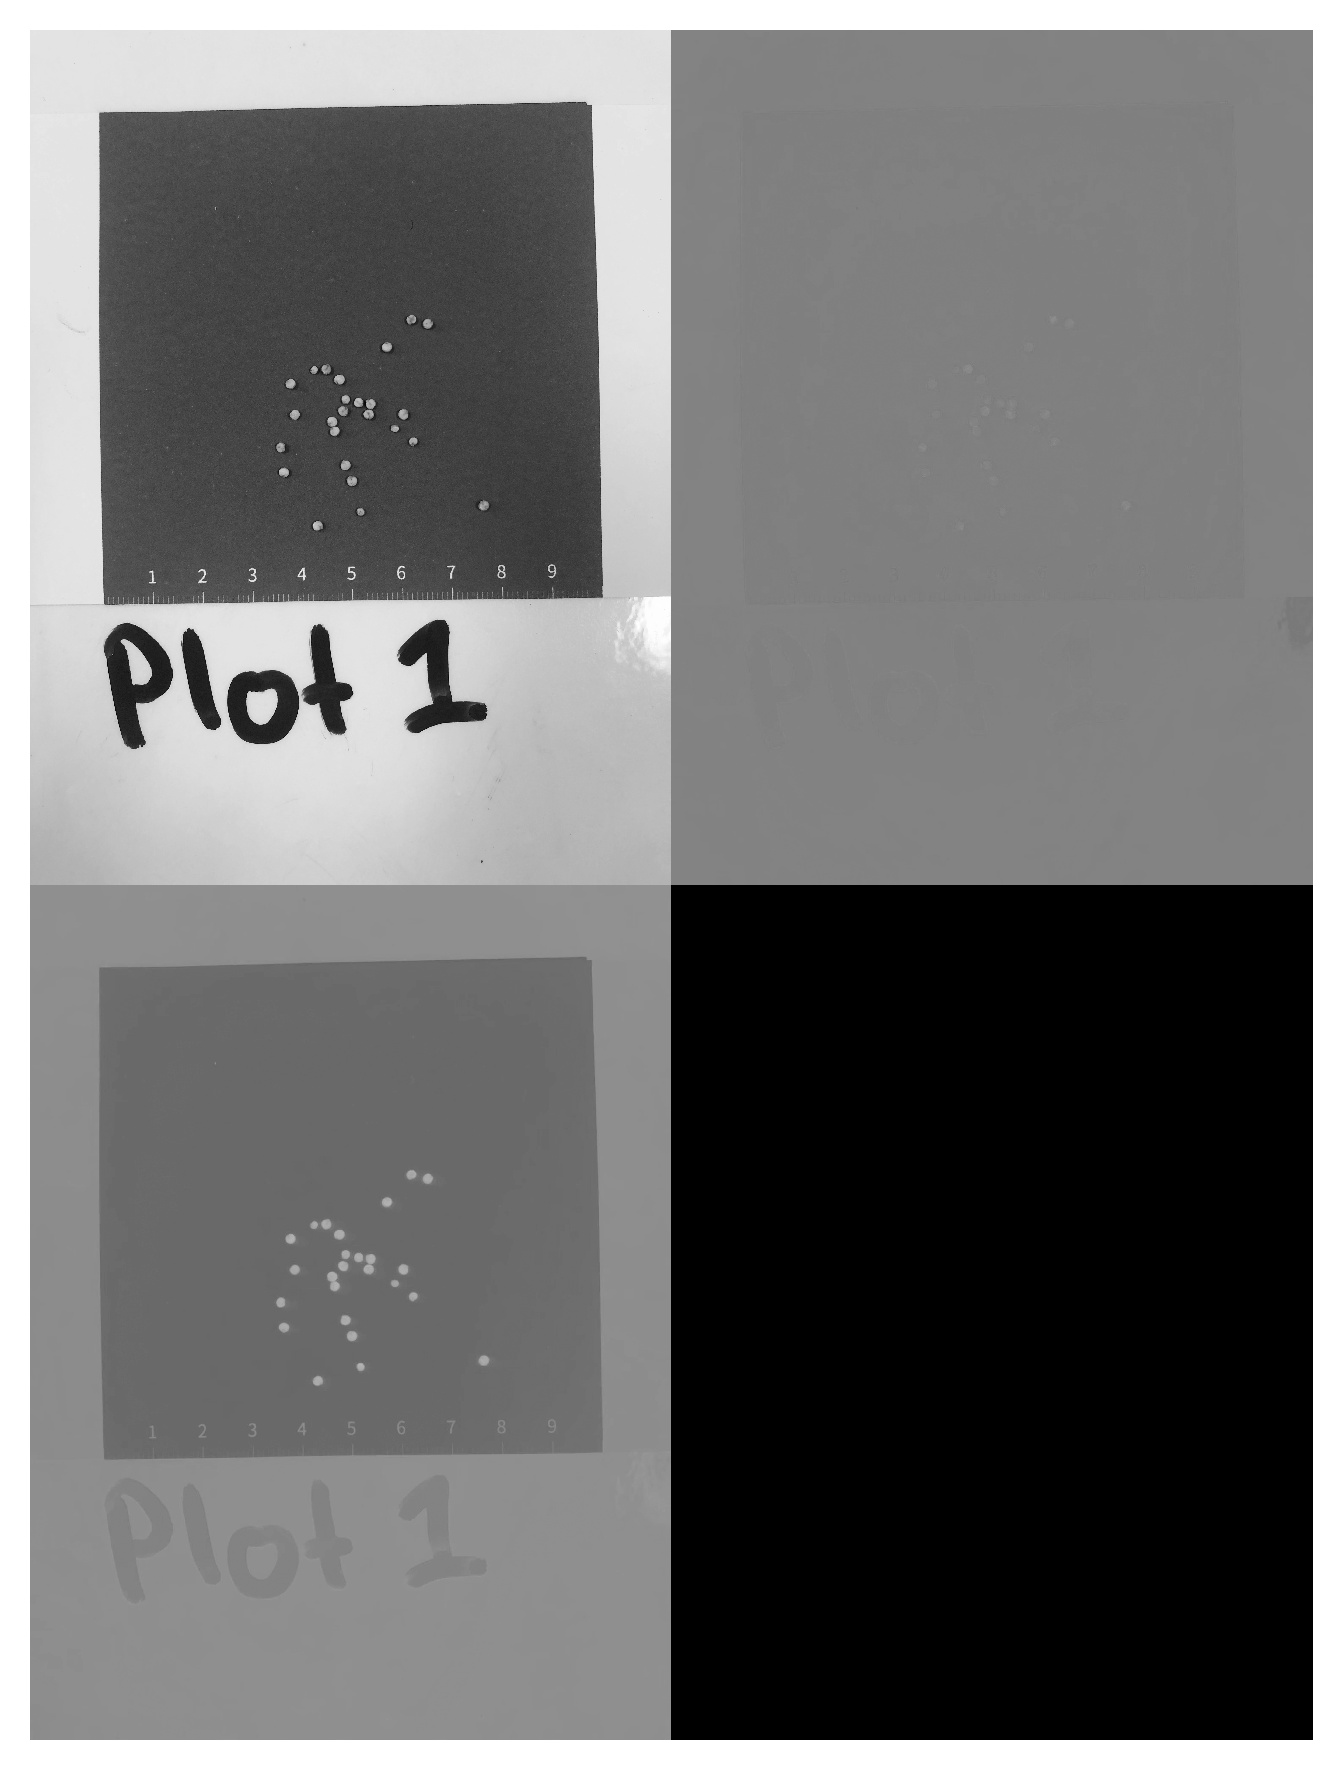

In [55]:
q.show_image(
    skimage.util.montage(np.moveaxis(img_lab, [-1], [0]), fill = 0)
)

(4032, 3024) uint8


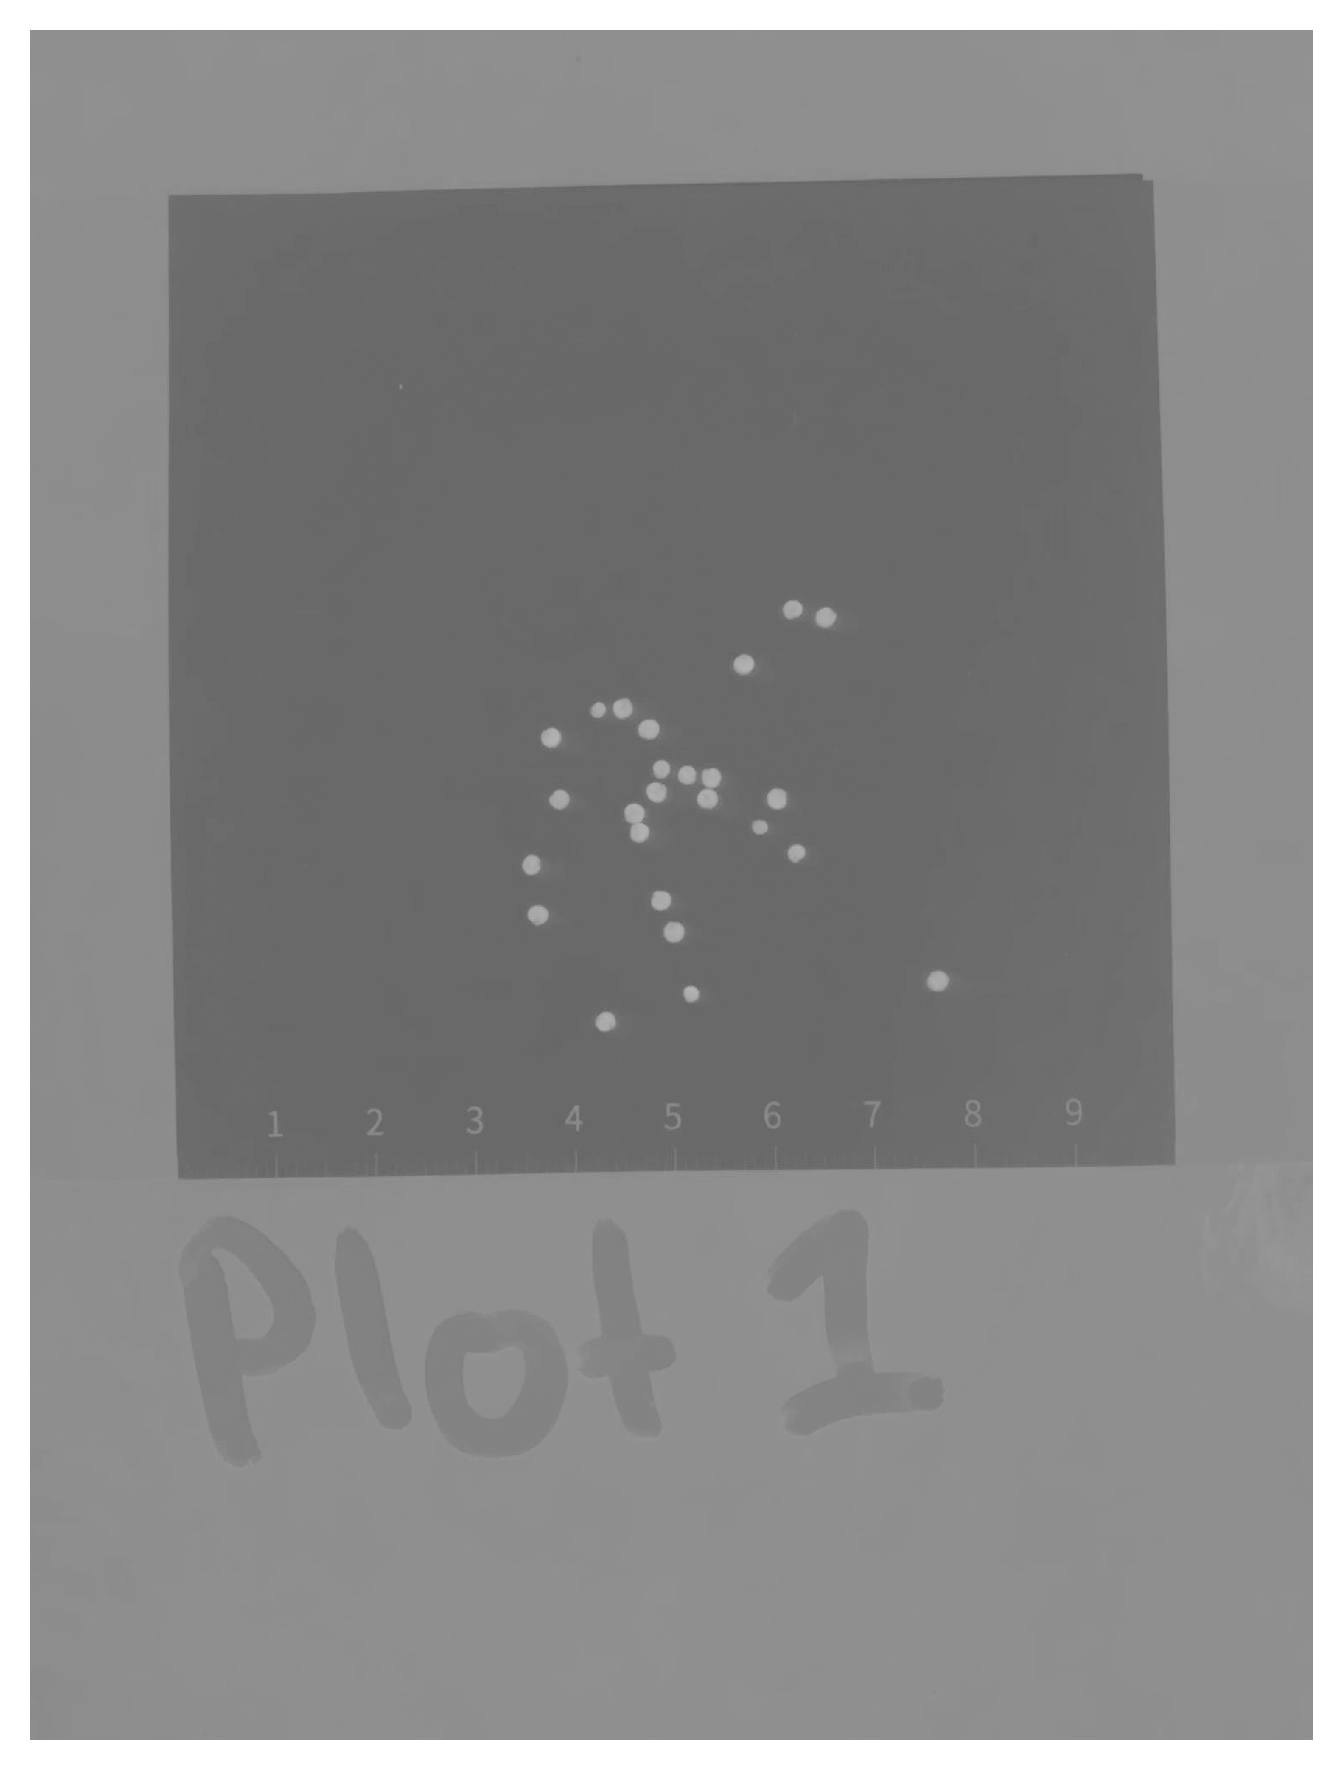

In [56]:
img_b = img_lab[..., 2]
print(img_b.shape, img_b.dtype)

q.show_image(img_b)

130.0


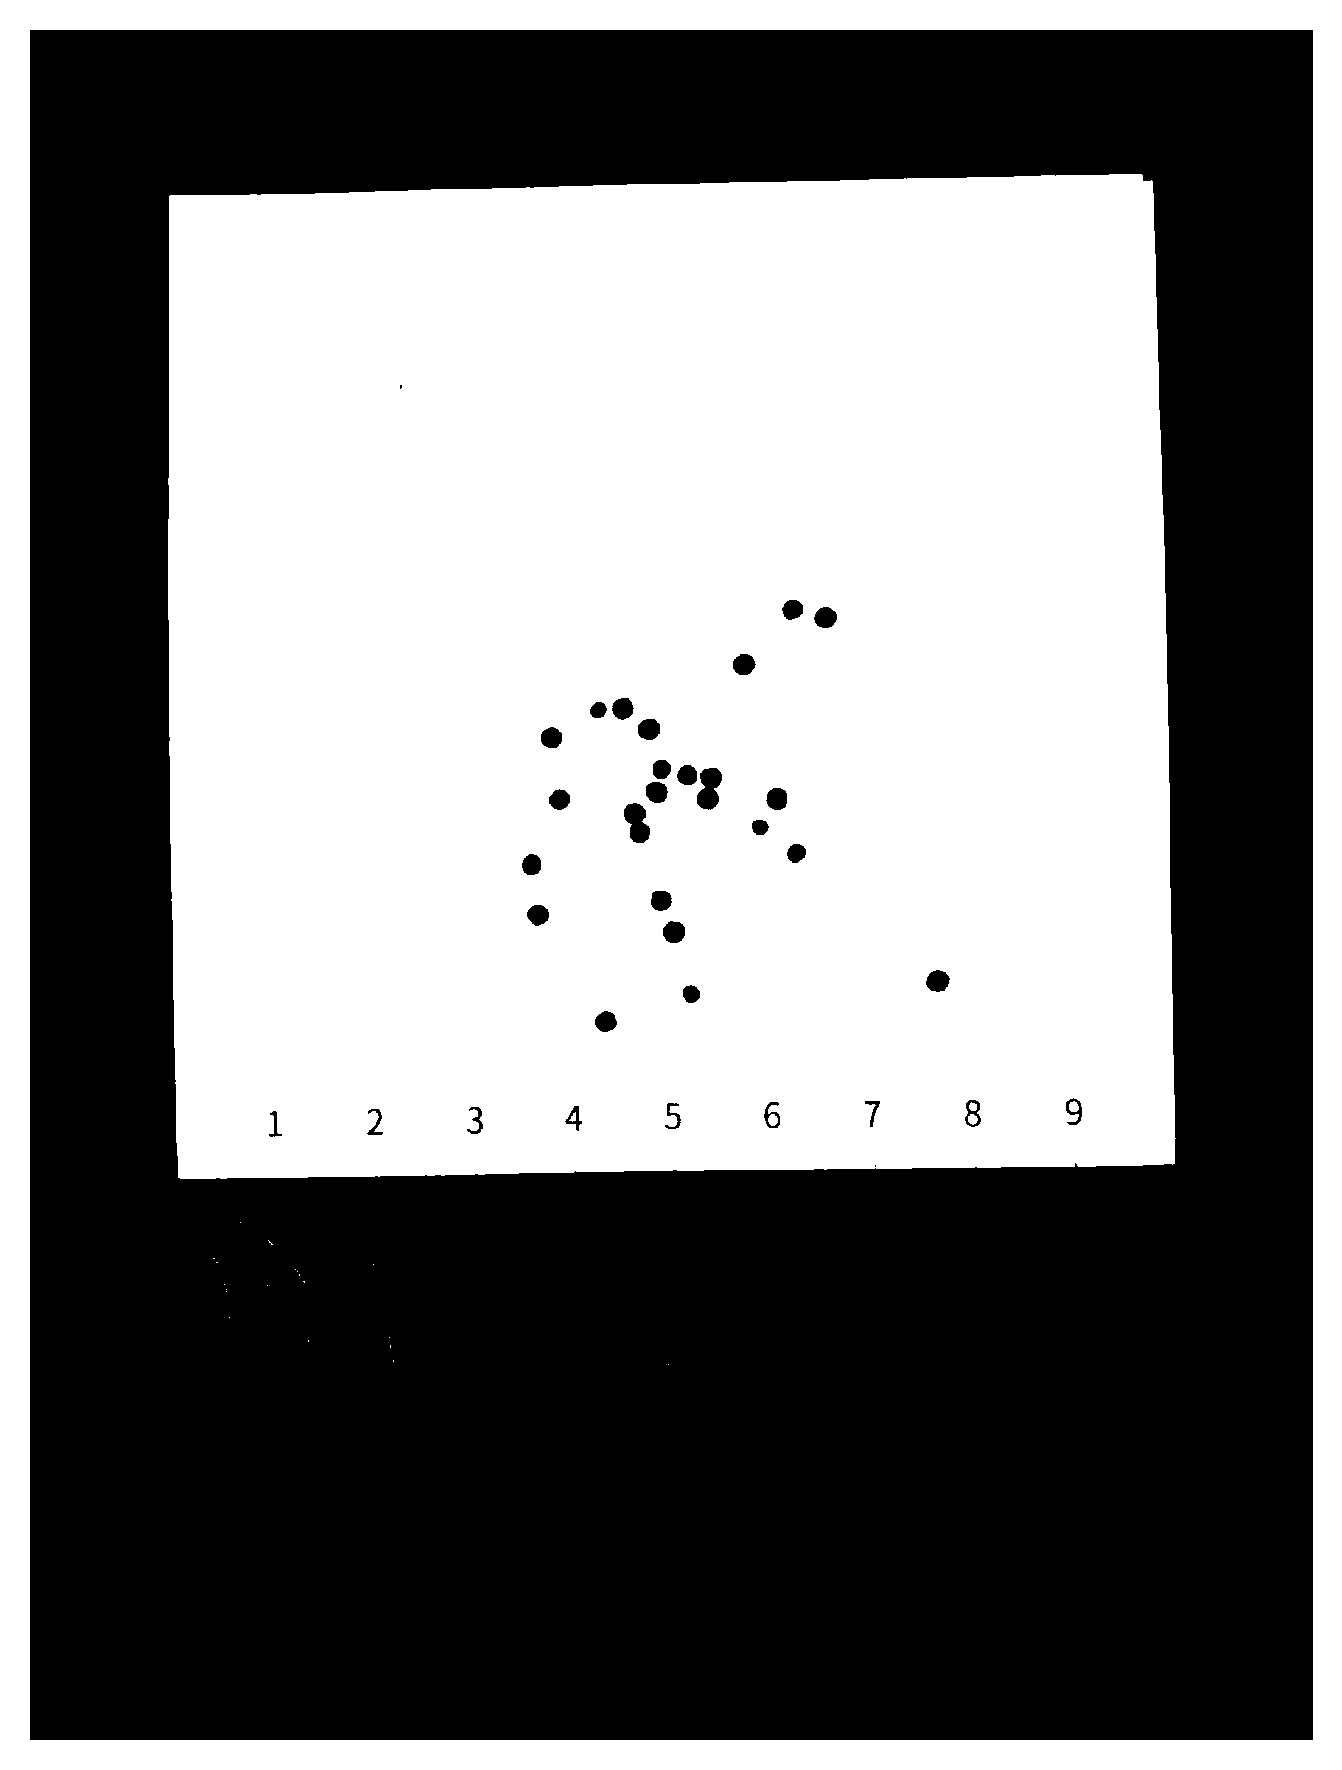

In [57]:
thresh, thresholded = cv.threshold(cv.bitwise_not(img_b), 0, maxval = 255, type = cv.THRESH_OTSU)

print(thresh)

q.show_image(thresholded)

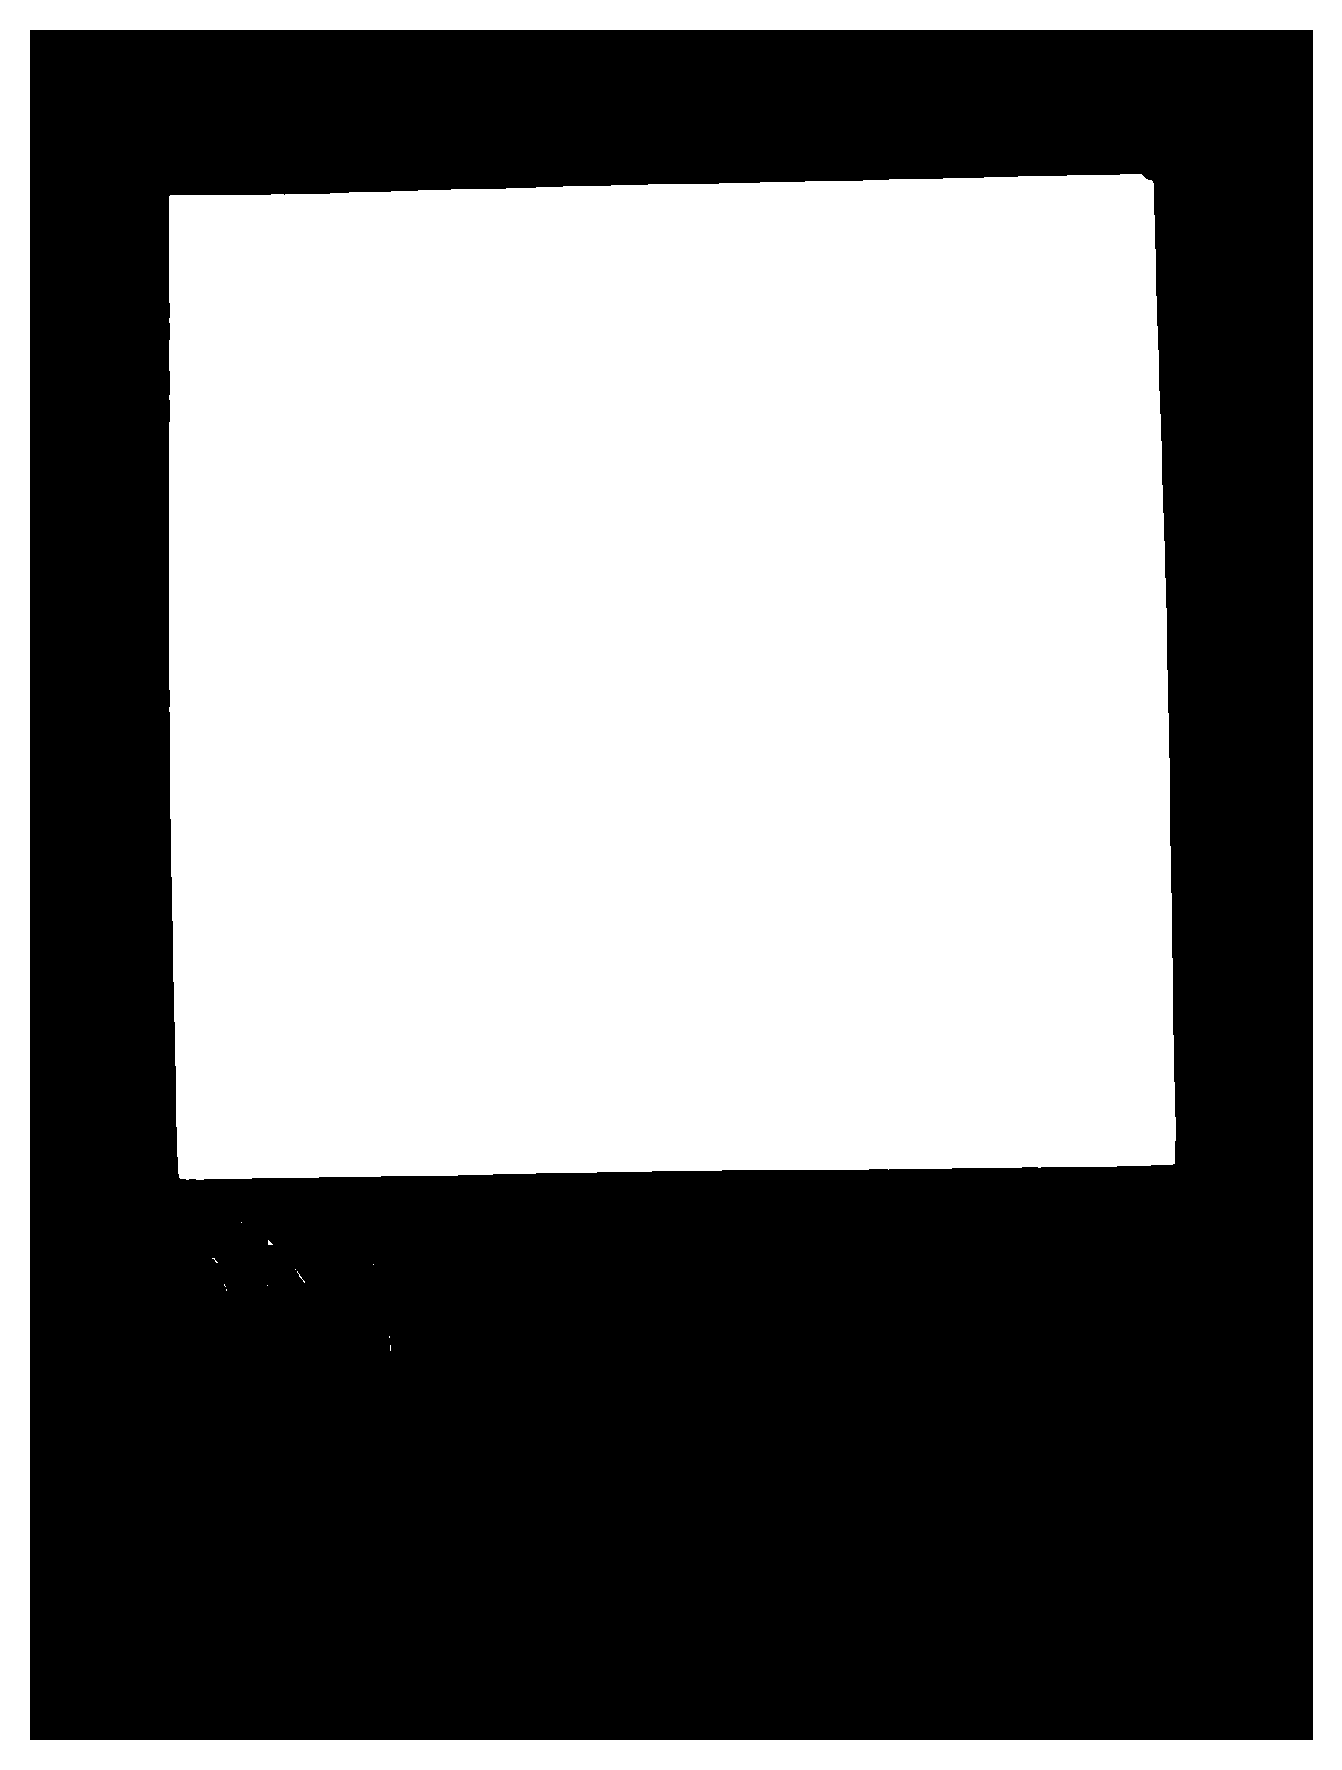

In [58]:
closed = cv.morphologyEx(
    thresholded,
    cv.MORPH_CLOSE,
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (50, 50))
)

q.show_image(closed)

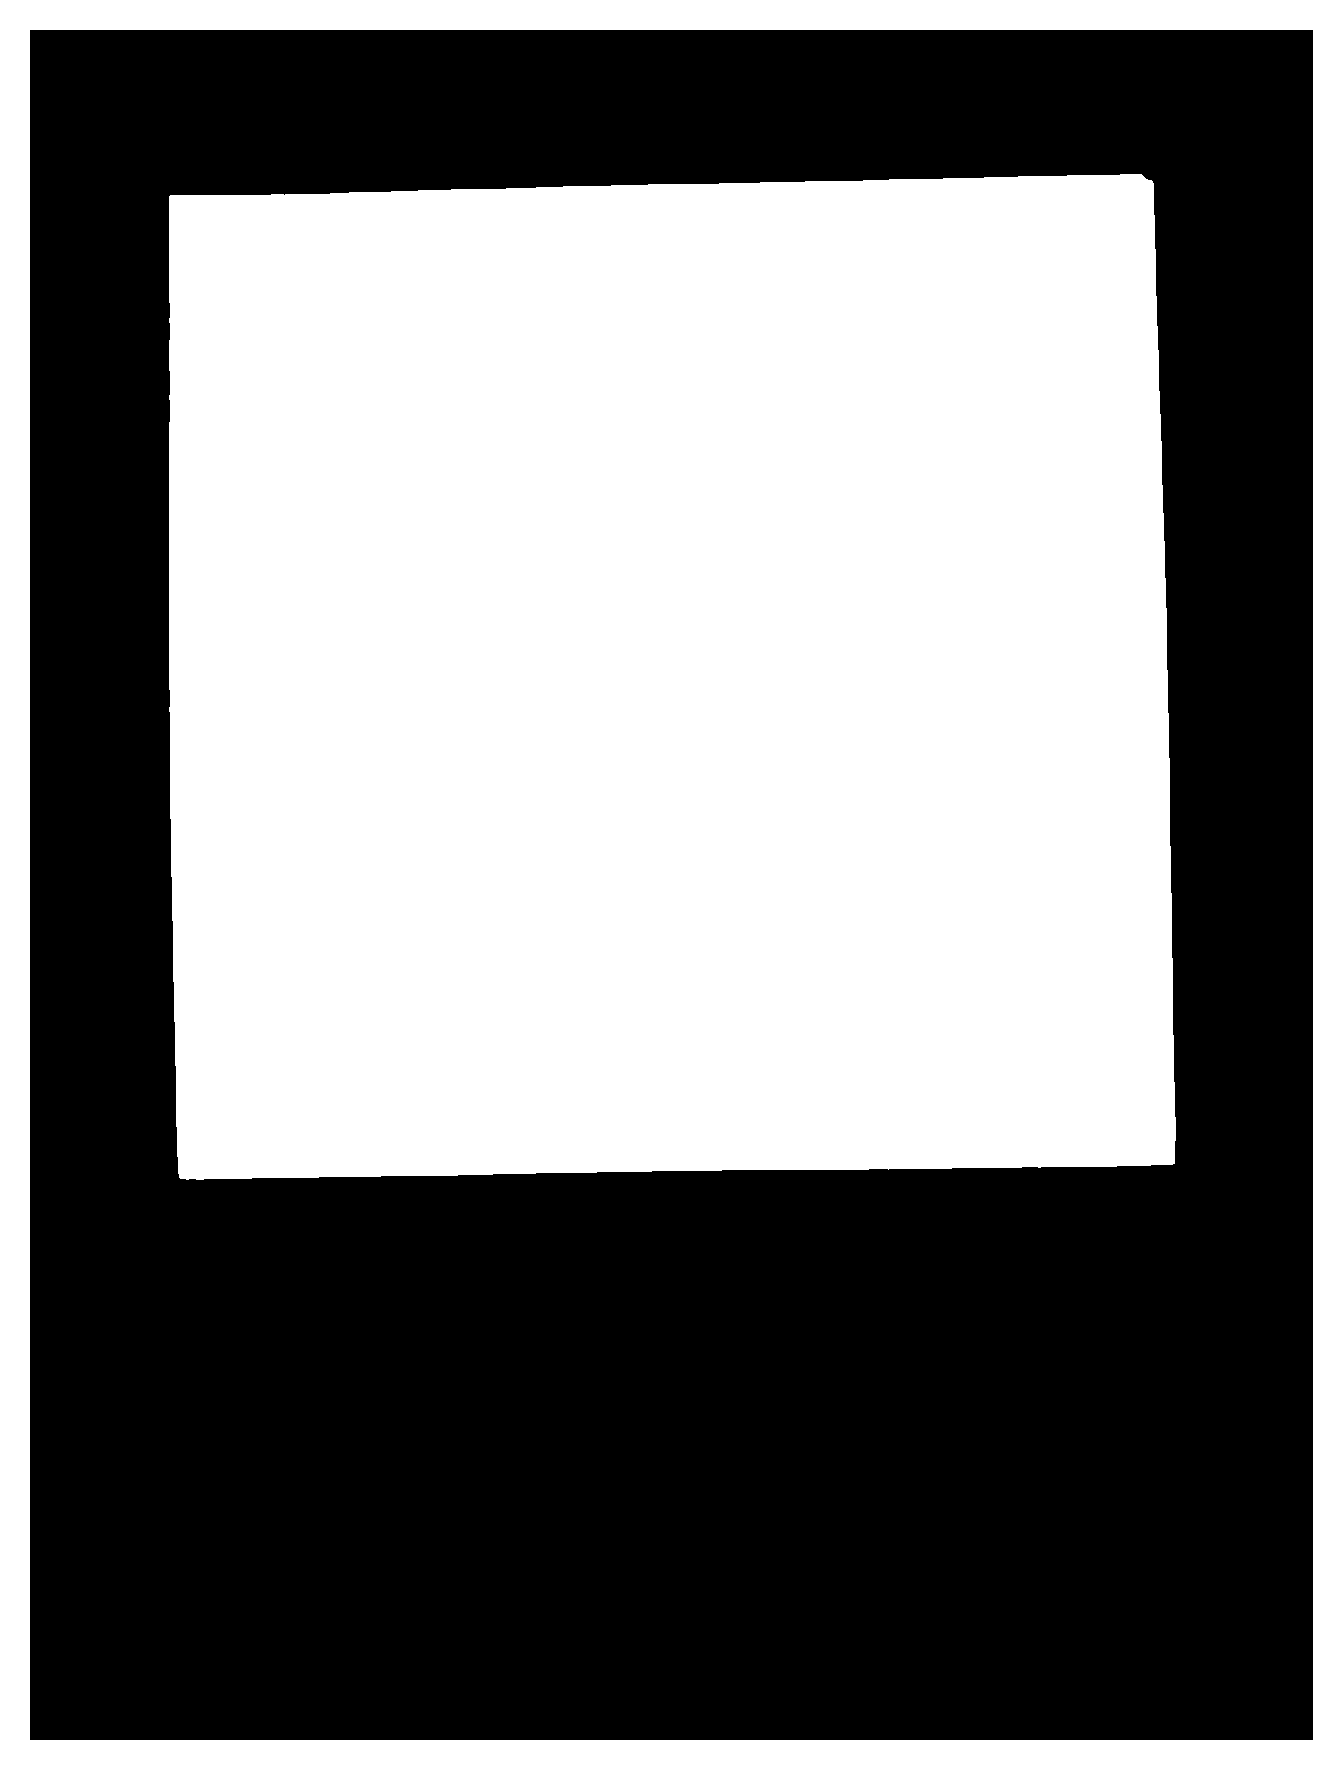

In [59]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(closed, connectivity = 8)

largest_label = max(range(1, num_labels), key = lambda label: stats[label, cv.CC_STAT_AREA])

just_largest_component = np.where(labels == largest_label, closed, 0)

q.show_image(just_largest_component)

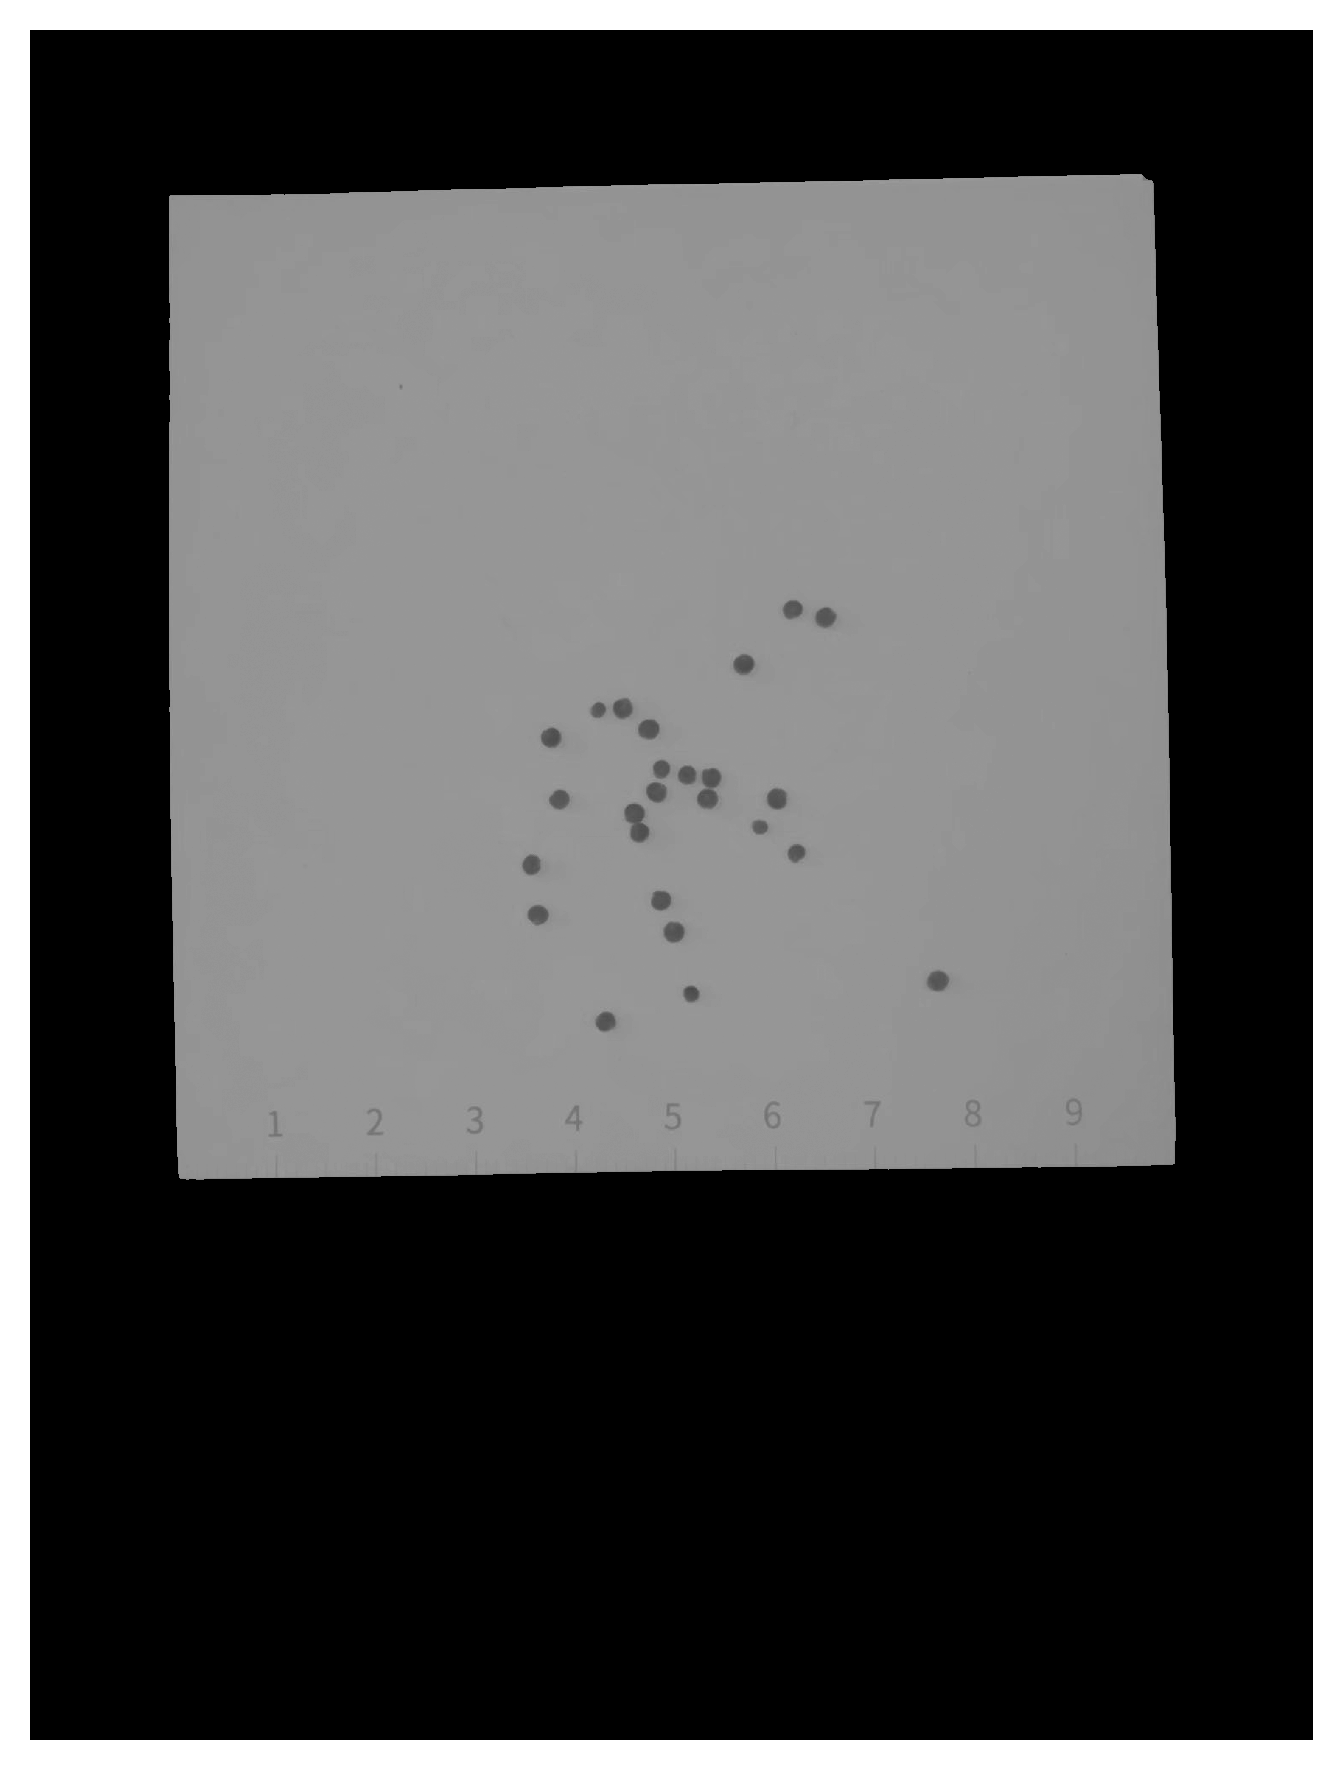

In [60]:
largest_component_on_original = np.where(labels == largest_label, cv.bitwise_not(img_b), 0)

q.show_image(largest_component_on_original)

In [61]:
mix = sklearn.mixture.GaussianMixture(n_components = 3)
clustered = mix.fit_predict(X = largest_component_on_original[largest_component_on_original != 0].ravel().reshape(-1, 1))

print(mix.means_)

[[149.35467169]
 [117.24538591]
 [146.5656208 ]]


In [62]:
show_clusters = np.zeros_like(img_b)
show_clusters[largest_component_on_original != 0] = clustered
show_clusters[largest_component_on_original == 0] = -1

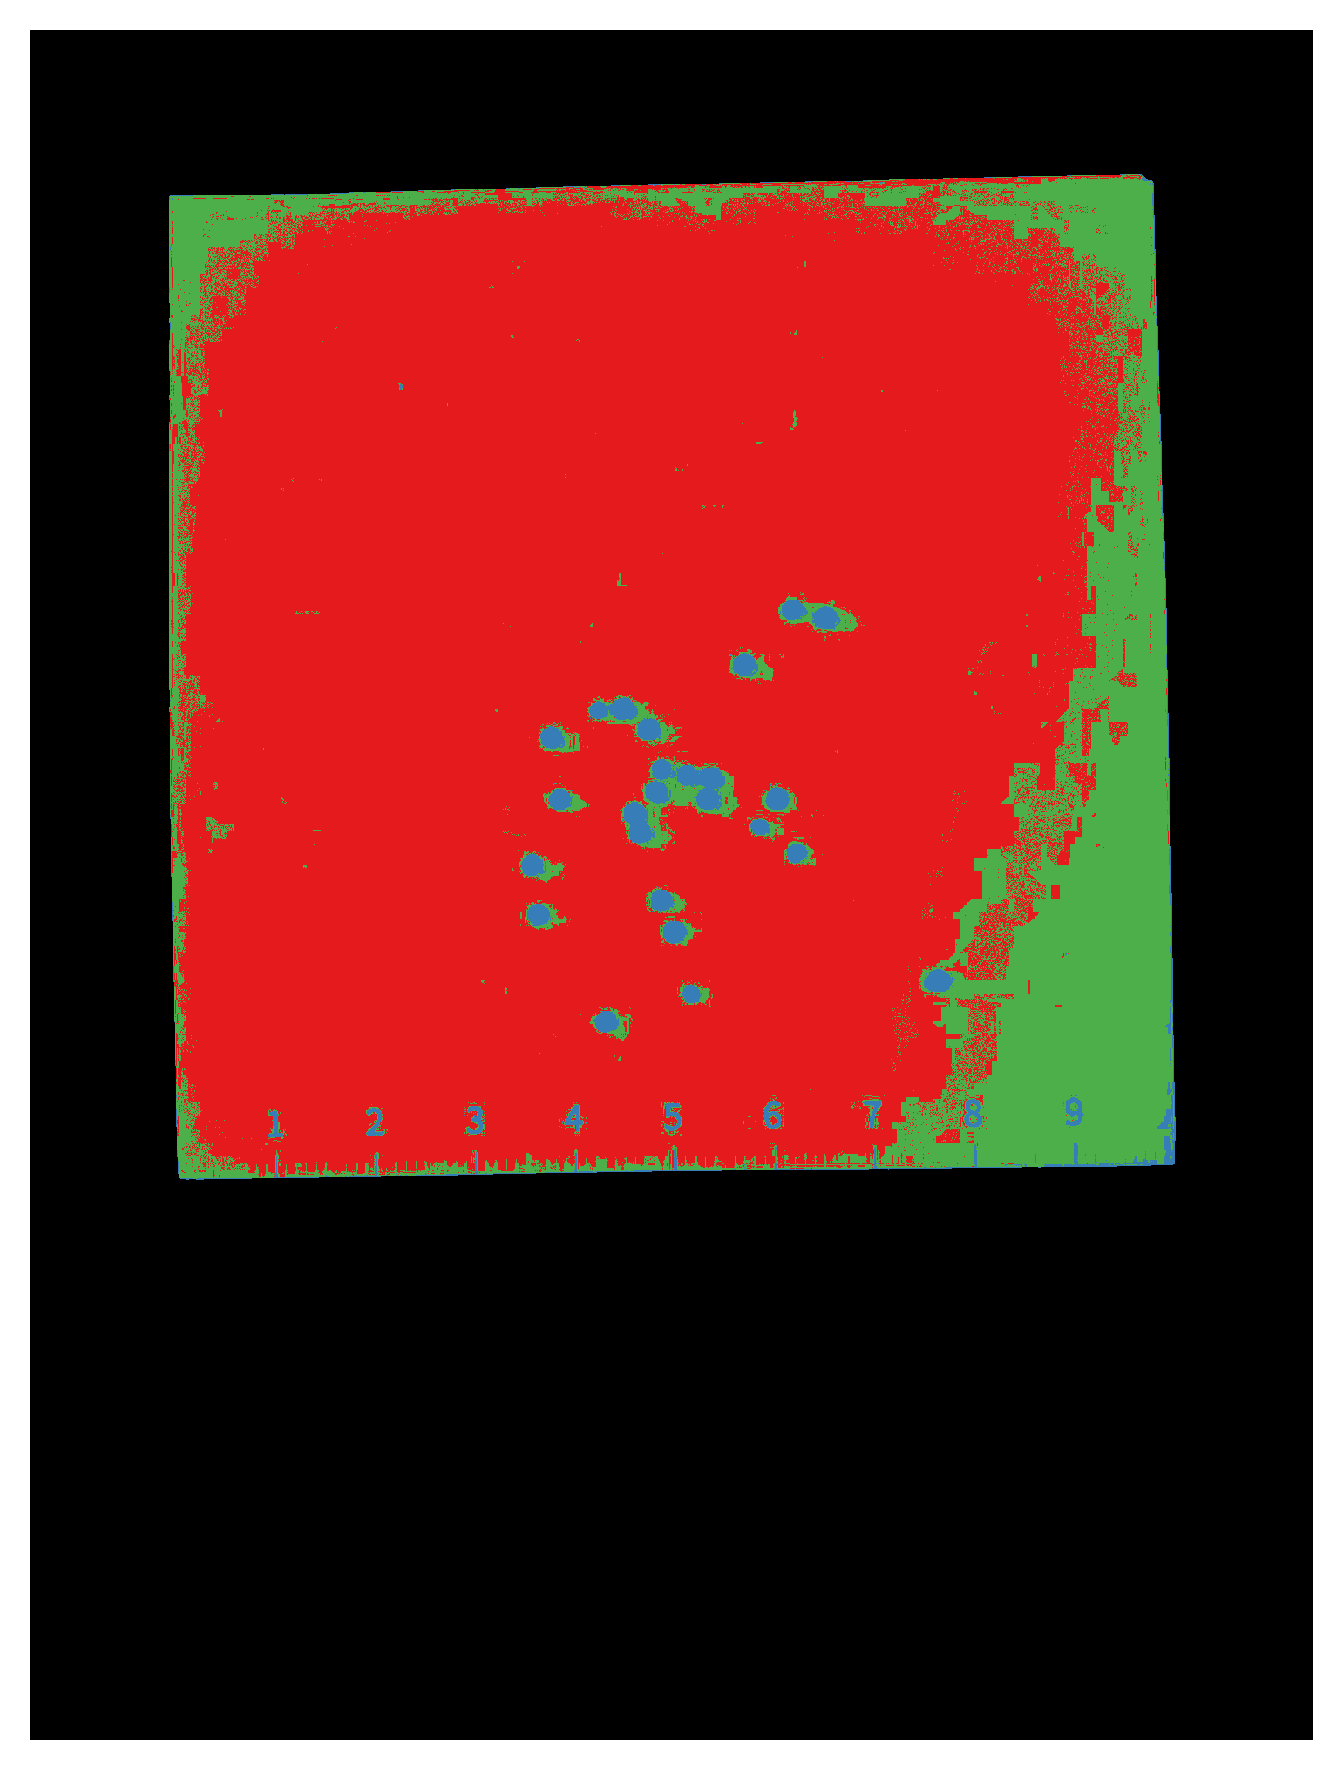

In [63]:
q.show_image(q.color_labels(img_bgr, label_range = range(3), labels = show_clusters))

0


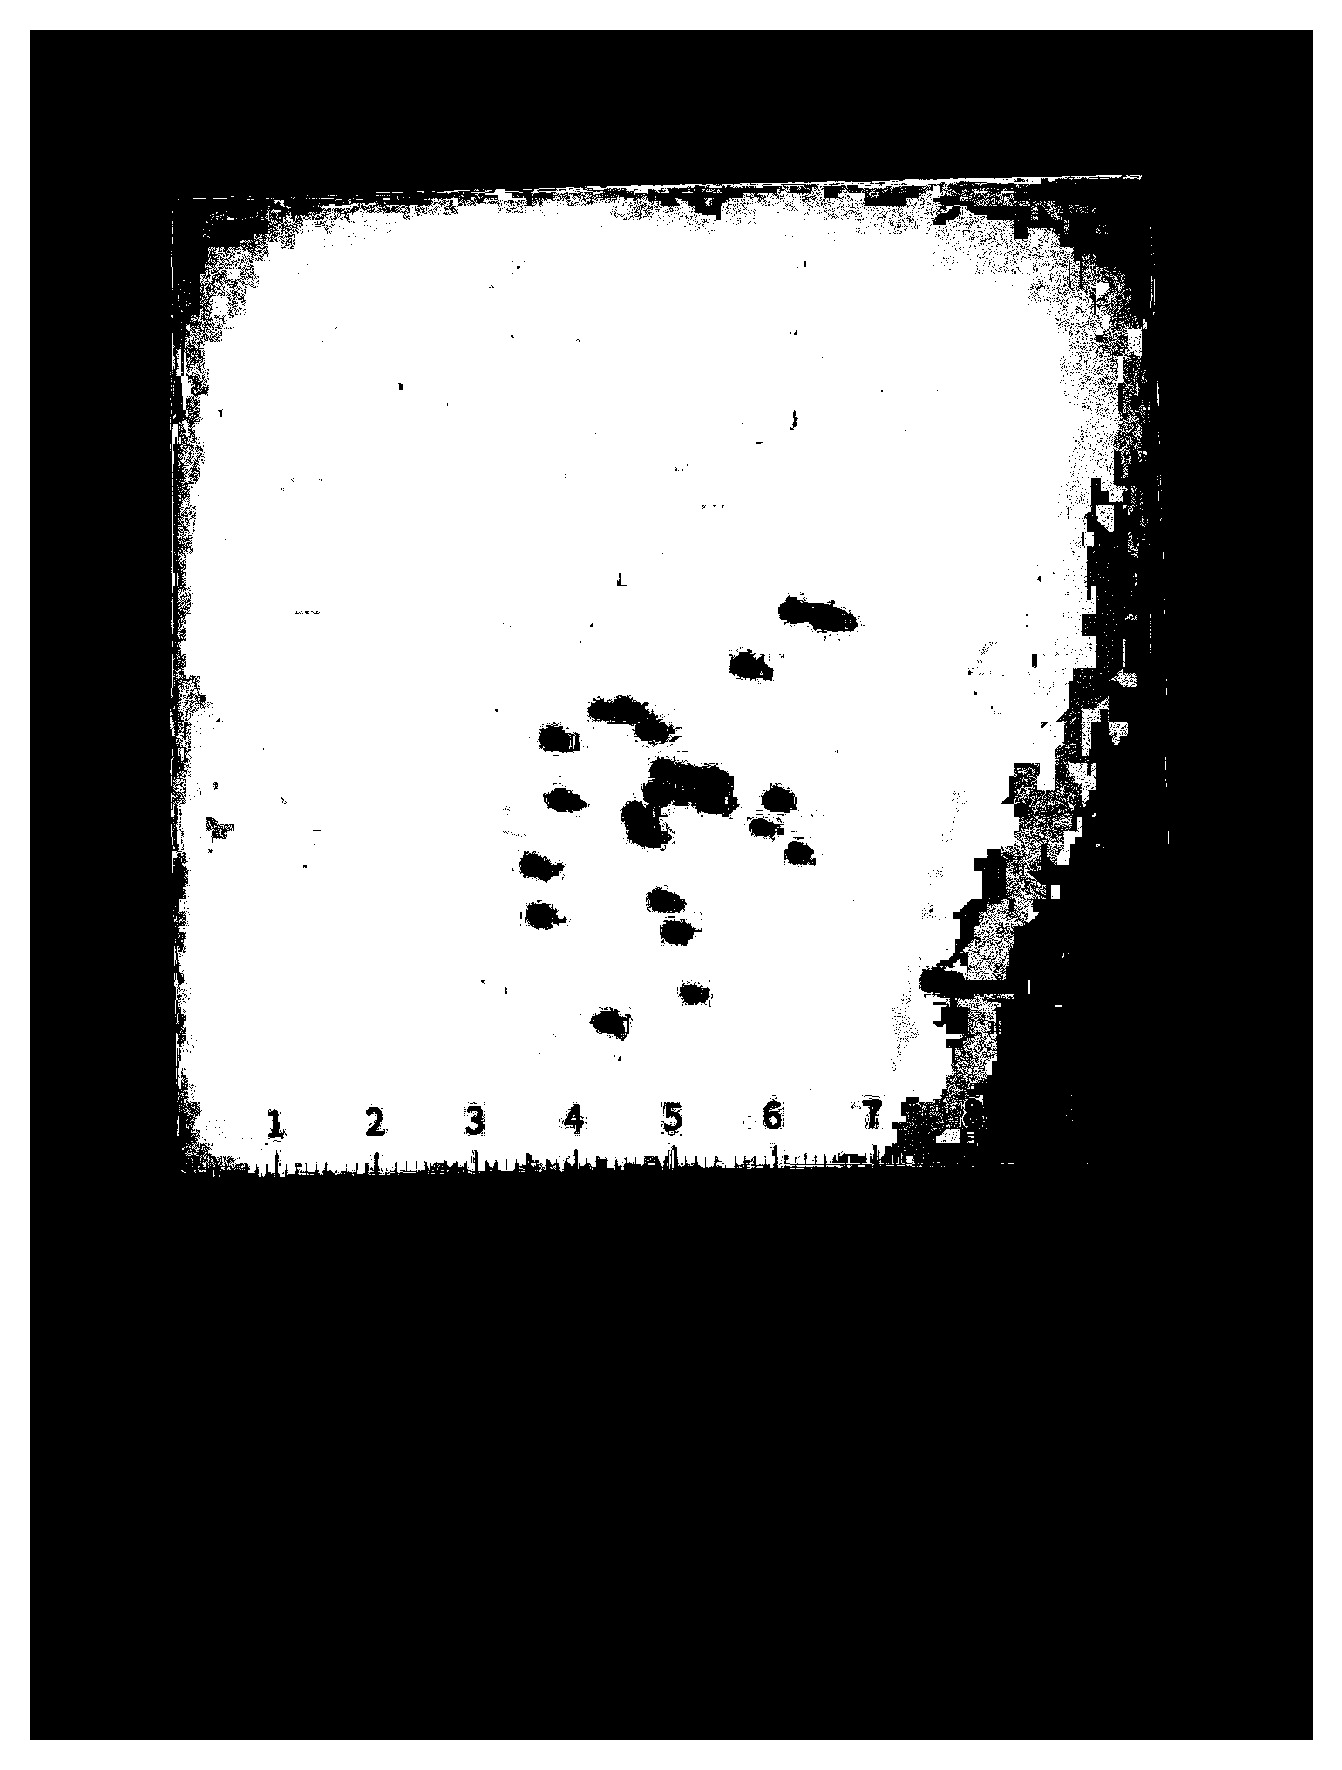

In [64]:
brightest = np.argmax(mix.means_)
print(brightest)

show_brightest = np.zeros_like(img_b)
show_brightest[show_clusters == brightest] = 255

q.show_image(show_brightest)


In [65]:
# edges = cv.Canny(cv.GaussianBlur(just_largest_component, (21, 21), 3), 10, 100, apertureSize = 7, L2gradient = True)
#
# q.show_image(edges)

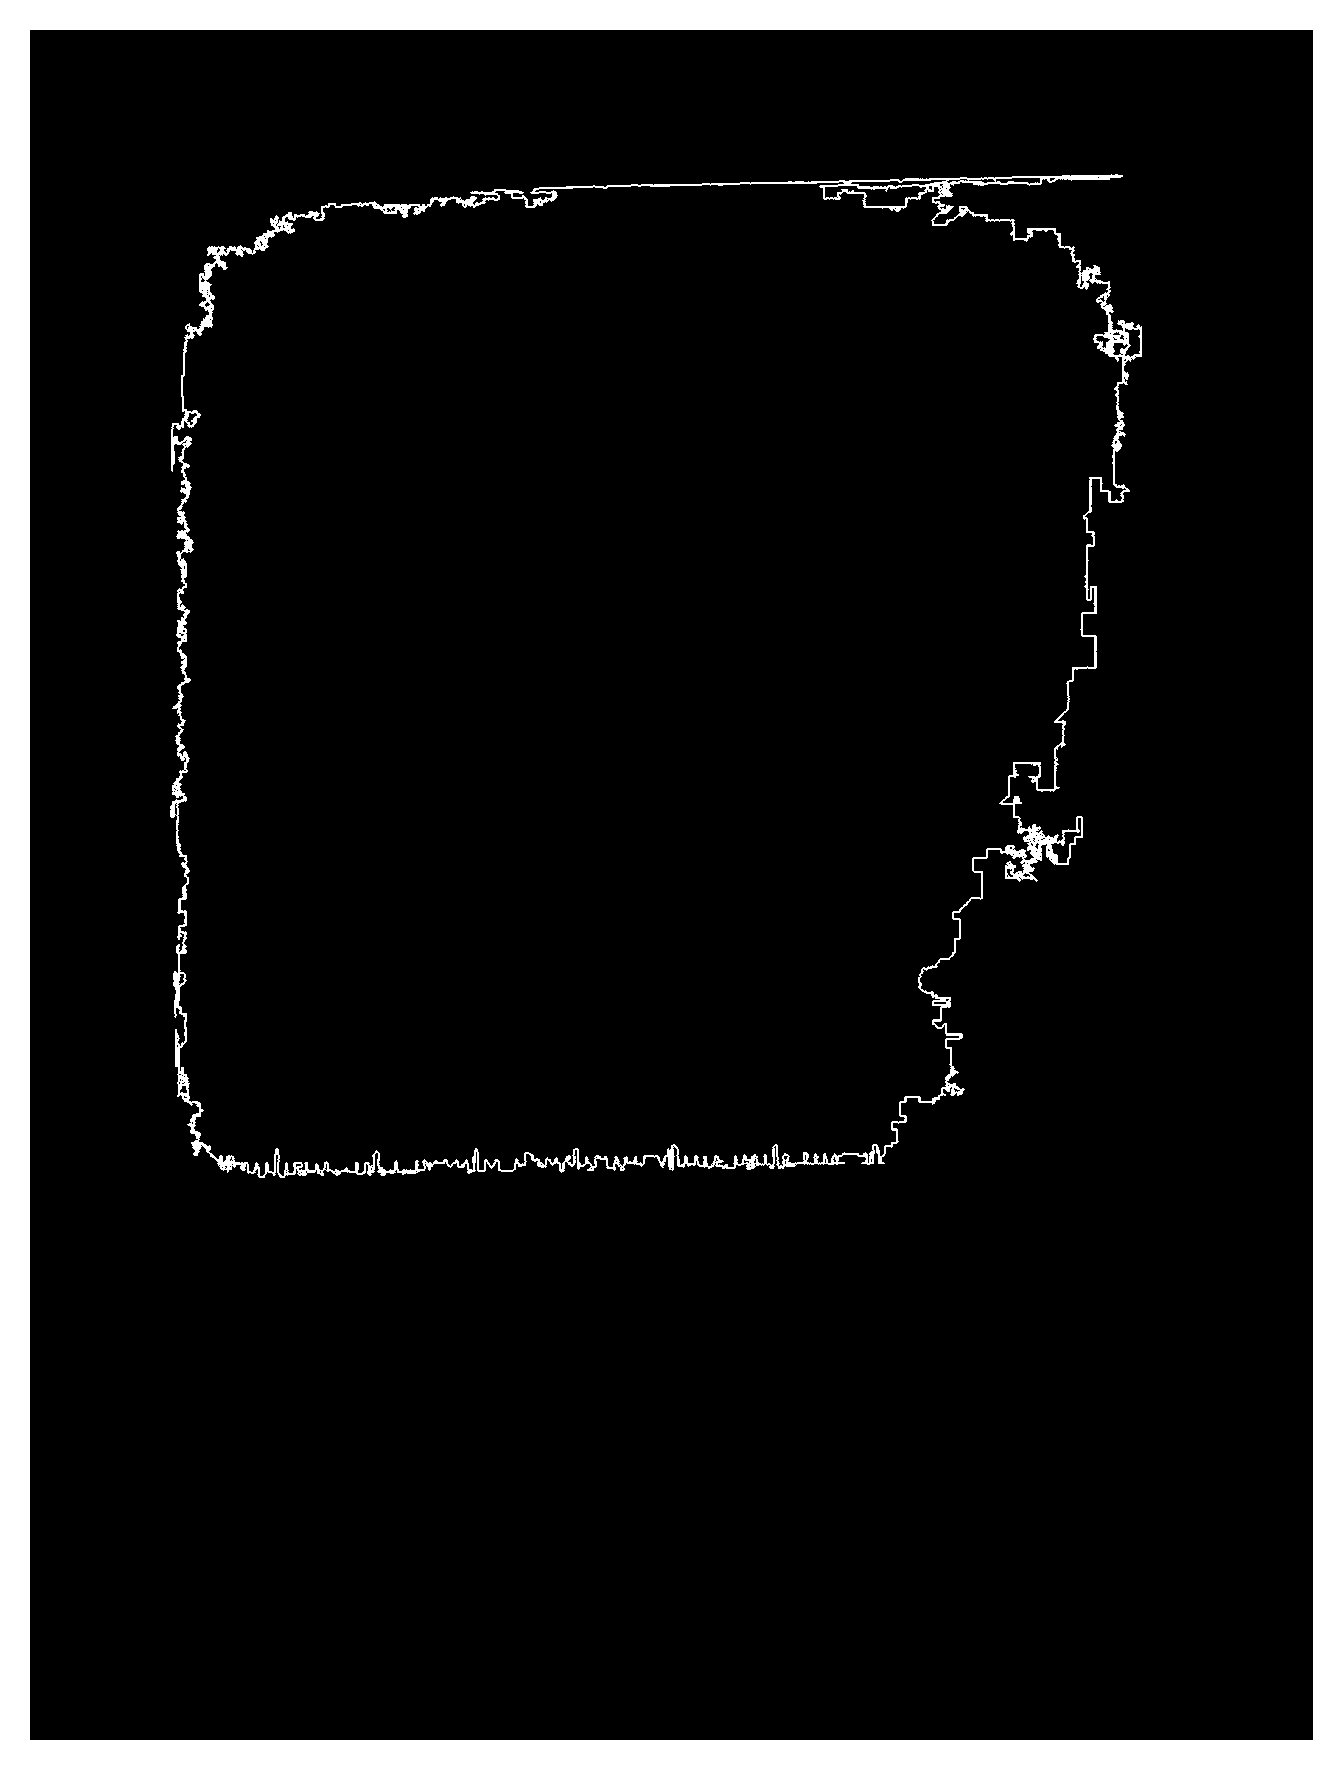

In [66]:
contours, hierarchy = cv.findContours(
    show_brightest, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE
)
# print(contours[-1])
contour = max(contours, key = lambda c: cv.contourArea(c))

show_contour = np.zeros_like(just_largest_component)
show_contour = cv.drawContours(show_contour, [contour], -1, (255,), thickness = 3)

q.show_image(show_contour)

In [67]:
# lines = cv.HoughLinesP(
#     show_contour,
#     rho = 10,
#     theta = np.deg2rad(2),
#     threshold = 100,
#     minLineLength = 200,
#     maxLineGap = 500,
# ).squeeze()
#
# print(lines.shape)
#
# show_lines = img_bgr.copy()
#
# for idx, ((xs, ys, xe, ye), color) in enumerate(zip(lines[:4], itertools.repeat(q.MAGENTA))):
#     show_lines = q.draw_arrow(
#         show_lines,
#         (xs, ys),
#         (xe, ye),
#         color = color,
#         thickness = 3,
#     )
#     show_lines = q.draw_text(
#         show_lines,
#         (xs - 20, ys - 20),
#         str(idx),
#         color = color,
#         size = 5,
#         thickness = 3,
#     )
#
# # show_lines = q.draw_rectangle(
# #     show_lines,
# #     (stats[largest_label, cv.CC_STAT_LEFT], stats[largest_label, cv.CC_STAT_TOP]),
# #     (stats[largest_label, cv.CC_STAT_LEFT] + stats[largest_label, cv.CC_STAT_WIDTH], stats[largest_label, cv.CC_STAT_TOP] + stats[largest_label, cv.CC_STAT_HEIGHT]),
# #     color = q.RED,
# #     thickness = 3,
# # )
#
# q.show_image(q.convert_colorspace(show_lines, cv.COLOR_BGR2RGB))

D:\projects\quinoa\quinoa\card.py:127: RuntimeWarning: divide by zero encountered in float_scalars
  )
D:\projects\quinoa\quinoa\card.py:128: RuntimeWarning: divide by zero encountered in float_scalars
  tl_corner_x, tl_corner_y = card_corners[0]


HoughLine(rho = 390.0, theta = 1.5533430576324463, slope = -0.01745504140853882, intercept = 390.05938720703125)
hor
HoughLine(rho = 360.0, theta = 0.0, slope = -inf, intercept = inf)
ver
HoughLine(rho = 380.0, theta = 0.01745329238474369, slope = -57.28996658325195, intercept = 21773.501953125)
ver
HoughLine(rho = 2700.0, theta = 1.5533430576324463, slope = -0.01745504140853882, intercept = 2700.4111328125)
hor
HoughLine(rho = 2670.0, theta = 1.5707963705062866, slope = 4.371138828673793e-08, intercept = 2670.0)
hor
HoughLine(rho = 2720.0, theta = 1.535889744758606, slope = -0.034920766949653625, intercept = 2721.657958984375)
hor
HoughLine(rho = 440.0, theta = 1.535889744758606, slope = -0.034920766949653625, intercept = 440.2681884765625)
hor
HoughLine(rho = 330.0, theta = 0.017453344660349757, slope = 57.289794921875, intercept = -18908.51171875)
ver
HoughLine(rho = 410.0, theta = 0.03490658476948738, slope = -28.636255264282227, intercept = 11748.0205078125)
ver
HoughLine(rho = 47

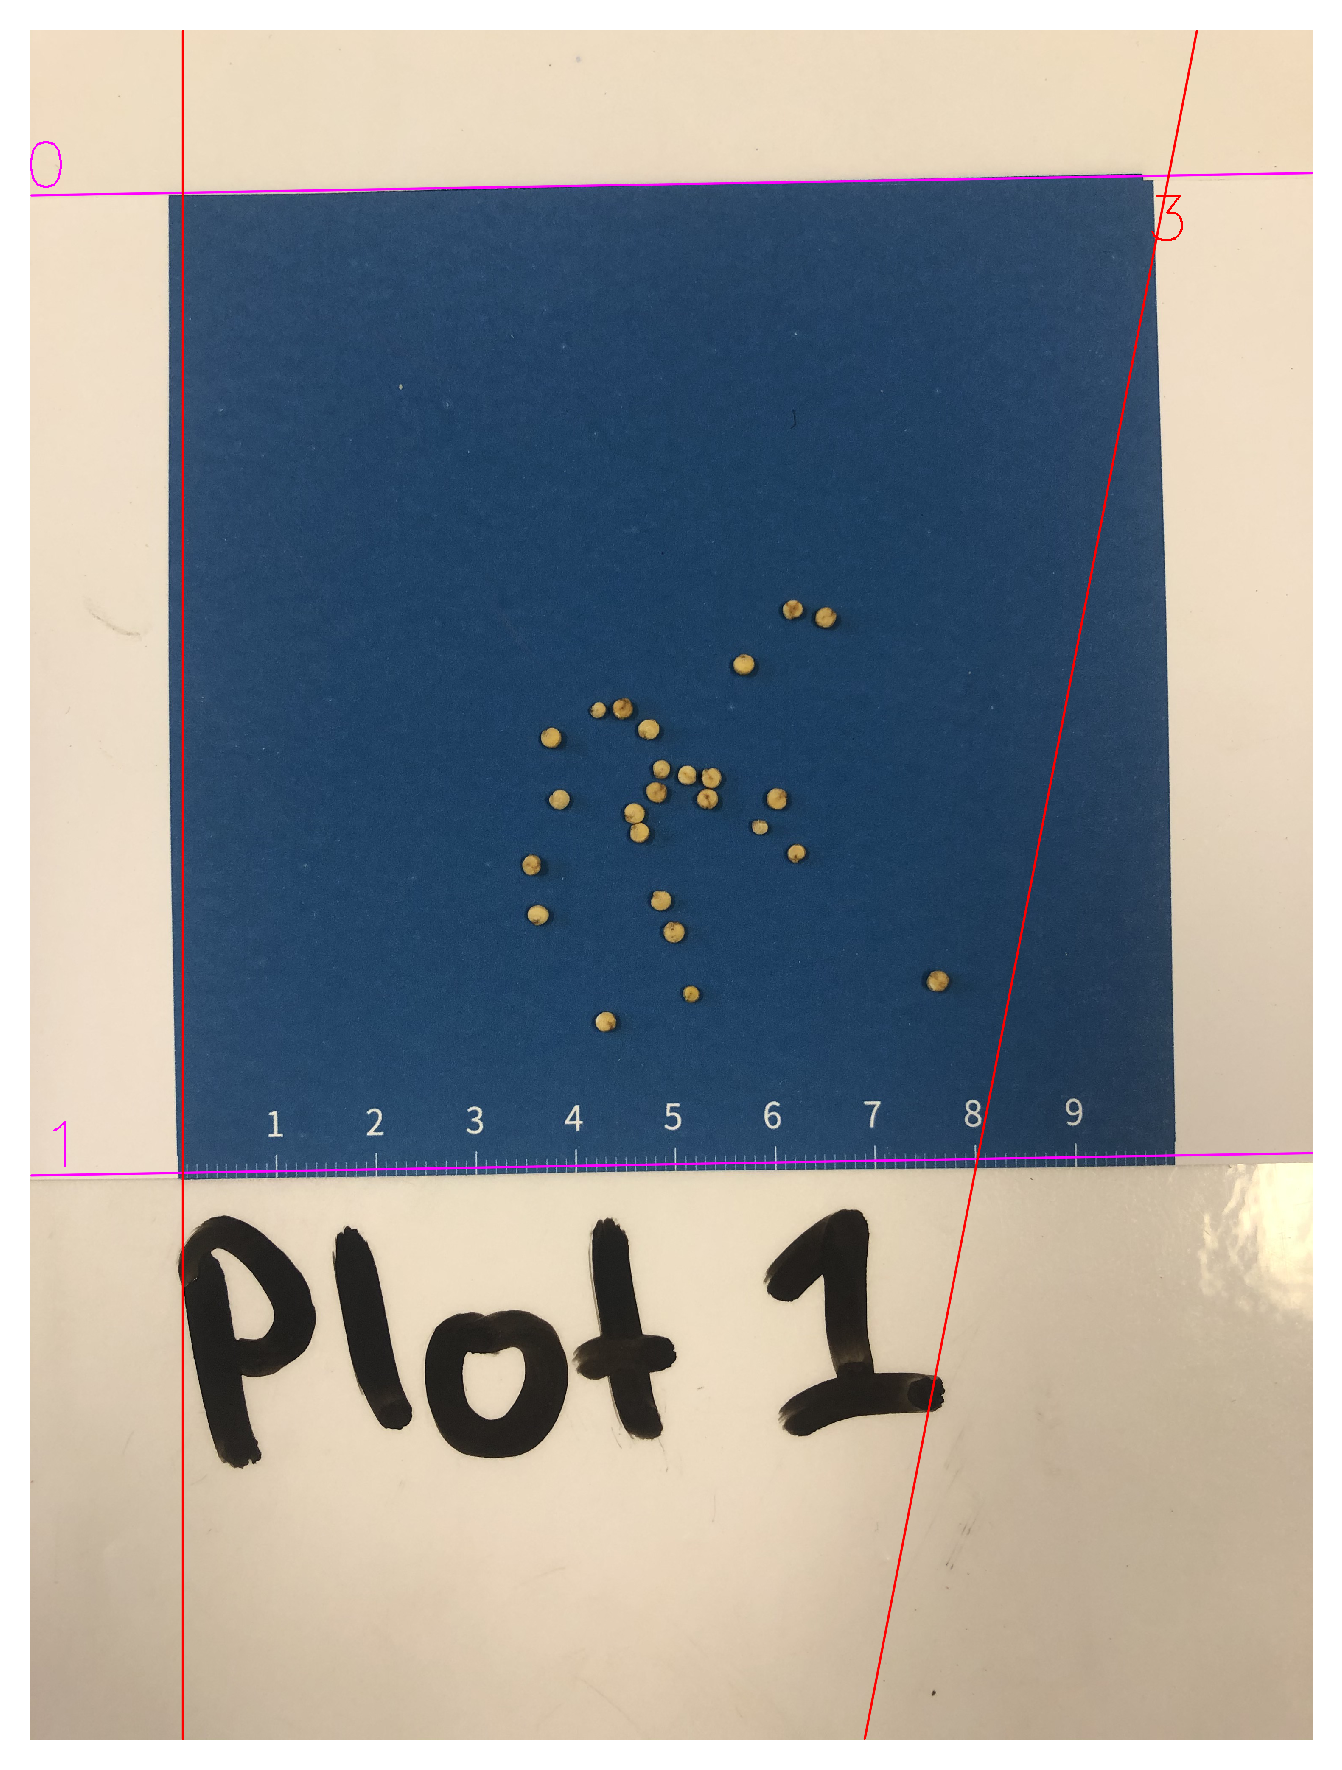

In [68]:
lines = cv.HoughLines(
    show_contour,
    rho = 10,
    theta = np.deg2rad(1),
    threshold = 100,
).squeeze()
# lines = lines[:4]
lines = [q.HoughLine(rho, theta) for rho, theta in lines]

horizontal = []
vertical = []
height, width = img_bgr.shape[:2]
for line in lines:
    print(line)
    if np.pi / 4 < line.theta < 3 * np.pi / 4:
        print('hor')
        if len(horizontal) == 0:
            horizontal.append(line)
        elif np.abs(horizontal[0].rho - line.rho) > width / 5:
            horizontal.append(line)
    else:
        print('ver')
        if len(vertical) == 0:
            vertical.append(line)
        elif np.abs(vertical[0].rho - line.rho) > height / 5:
            vertical.append(line)

    if len(horizontal) >= 2 and len(vertical) >= 2:
        break

horizontal = horizontal[:2]
vertical = vertical[:2]

show_lines = img_bgr.copy()

print(horizontal)
print(vertical)

for idx, (line, color) in enumerate(zip(horizontal + vertical, [q.MAGENTA, q.MAGENTA, q.RED, q.RED])):
    a = np.cos(line.theta)
    b = np.sin(line.theta)
    x0 = a*line.rho
    y0 = b*line.rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))

    show_lines = q.draw_line(
        show_lines,
        (x1, y1),
        (x2, y2),
        color = color,
        thickness = 3,
    )
    show_lines = q.draw_text(
        show_lines,
        (x0 - 20, y0 - 20),
        str(idx),
        color = color,
        size = 5,
        thickness = 3,
    )

q.show_image(show_lines)